In [1]:
from expl_bind_vertex_calc import *
import time
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import scipy as sp
from matplotlib.colors import LogNorm
import matplotlib as mpl

In [2]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT
# e_m = np.array([1, 1]) #binding energy FOR F_BIND_ALT
# e_m = np.array([4, 4]) #binding energy FOR F_BIND_ALT

# e_m = np.array([0.52, 0.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_s = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# test
# mu_max_1 = -2-1.5#8#0.1 #10
# mu_min_1 = -4-1.5#-9
# # mu_min_1 = -8-1.5#-9
# del_mu_1 = 0.1#.5 #0.25
# mu_max_2 = mu_max_1
# mu_min_2 = mu_min_1
# del_mu_2 = del_mu_1

# phi_Au_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
# phi_Bu_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 100/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = 1
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [3]:
phi_Au_arr = np.arange(0.001, 0.07, 0.01)
# phi_Au_arr = np.arange(0.001, 0.1, 0.01)

phi_Bu_arr = phi_Au_arr

muA_mat, muB_mat, sA_mat, sB_mat, \
fA_mat, fB_mat, phi_Au_mat, phi_Bu_mat, phi_Ab_mat,\
phi_Bb_mat = calc_mu_phi_bind(psol, phi_Au_arr, phi_Bu_arr)

In [4]:
muA_mat[0,-1]

-6.734898222267657

In [5]:
muB_mat[0,-1]

-2.793999153570916

In [6]:
muA_mat[-1,0]

-2.793999153570916

In [7]:
muB_mat[-1,0]

-6.734898222267657

In [8]:
phi_Au_mat[0,-1]

0.001

In [9]:
phi_Bu_mat[-1,0]

0.001

In [10]:
phi_Au_mat[-1,0]

0.06099999999999999

In [11]:
phi_Bu_mat[0,-1]

0.06099999999999999

In [12]:
phi_Ab_mat[0,-1]

0.0007293567427460291

In [13]:
phi_Bb_mat[-1,0]

0.0007293567427460291

In [14]:
fA_mat[0,-1]

0.0024311891424867635

In [15]:
fB_mat[-1,0]

0.0024311891424867635

In [16]:
# compare [0, -1] to [-1, 0]
sA_mat[0,-1][::-1]# == sB_mat[-1,0]

array([0.00429086, 0.00420519, 0.0041202 , 0.00403591, 0.0039523 ,
       0.00386936, 0.00378709, 0.00370547, 0.0036245 , 0.00354418,
       0.00346448, 0.00338542, 0.00330697, 0.00322913, 0.0031519 ,
       0.00307526, 0.00299921, 0.00292375, 0.00284887, 0.00277455,
       0.0027008 , 0.00262761, 0.00255497, 0.00248287, 0.00241131,
       0.00234028, 0.00226979, 0.00219981, 0.00213035, 0.00206139,
       0.00199294, 0.00192499, 0.00185754, 0.00179057, 0.00172408,
       0.00165807, 0.00159253, 0.00152746, 0.00146285, 0.0013987 ,
       0.001335  , 0.00127175, 0.00120894, 0.00114657, 0.00108464,
       0.00102313, 0.00096205, 0.00090139, 0.00084114, 0.00078131])

In [17]:
sB_mat[-1,0]

array([0.00429086, 0.00420519, 0.0041202 , 0.00403591, 0.0039523 ,
       0.00386936, 0.00378709, 0.00370547, 0.0036245 , 0.00354418,
       0.00346448, 0.00338542, 0.00330697, 0.00322913, 0.0031519 ,
       0.00307526, 0.00299921, 0.00292375, 0.00284887, 0.00277455,
       0.0027008 , 0.00262761, 0.00255497, 0.00248287, 0.00241131,
       0.00234028, 0.00226979, 0.00219981, 0.00213035, 0.00206139,
       0.00199294, 0.00192499, 0.00185754, 0.00179057, 0.00172408,
       0.00165807, 0.00159253, 0.00152746, 0.00146285, 0.0013987 ,
       0.001335  , 0.00127175, 0.00120894, 0.00114657, 0.00108464,
       0.00102313, 0.00096205, 0.00090139, 0.00084114, 0.00078131])

In [18]:
np.sum(np.round(sA_mat[0,-1][::-1],7) == np.round(sB_mat[-1,0], 7)) / len(sB_mat[0,-1])

1.0

In [19]:

chi_AP = 0
chi_BP = 0
# chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0

# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]))) 

cond_num_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

for i in range(len(phi_Au_arr)):
    for j in range(len(phi_Bu_arr)):
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        s_bnd_A = sA_mat[i,j]
        s_bnd_B = sB_mat[i,j]

        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]

        phius = [phi_Au, phi_Bu]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):

            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, k)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [20]:
# plot such that when spinodal = -1, disordered; when k_star = k_vec[0], macro; else, micro
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro
# spinodal

In [21]:
muA_mat[:,0]

array([-6.90470328, -4.50684003, -3.86024322, -3.47080729, -3.19124986,
       -2.97302244, -2.79399915])

In [22]:
np.round(muA_mat[0,:],3)

array([-6.905, -6.875, -6.845, -6.817, -6.789, -6.762, -6.735])

In [23]:
np.round(muA_mat[0,:],1)

array([-6.9, -6.9, -6.8, -6.8, -6.8, -6.8, -6.7])

Text(0.5, 49.7222222222222, '~$\\mu^{(2)}$')

<Figure size 640x480 with 0 Axes>

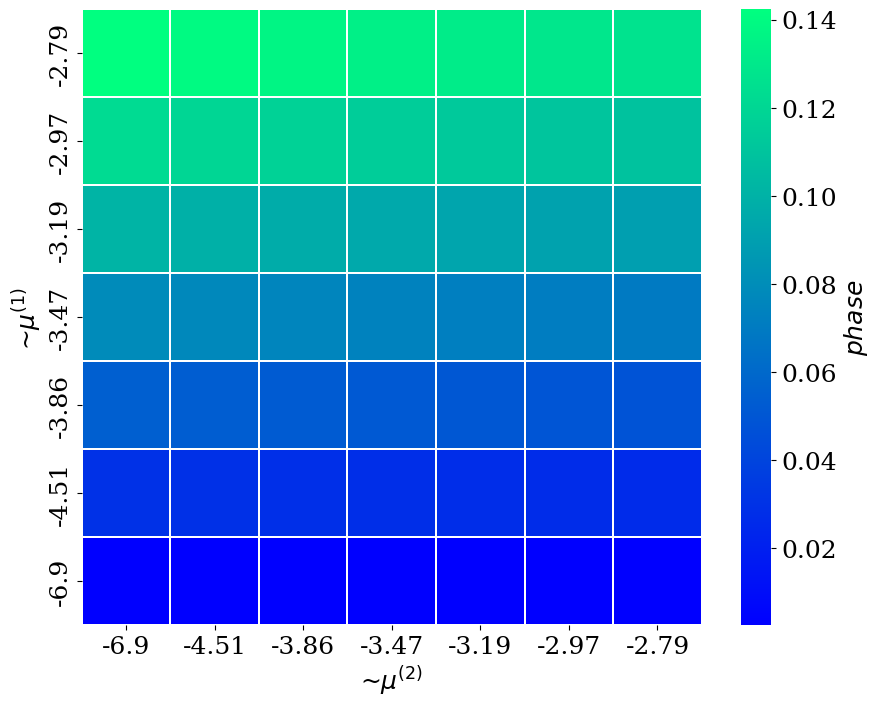

In [24]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(fA_mat, linewidth=0.25, cmap = "winter", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
                 cbar_kws={'label':  r"$phase$"})#, vmin=0, vmax=1)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("~$\mu^{(1)}$")
plt.xlabel("~$\mu^{(2)}$")

Text(0.5, 1.0, '$with \\ unbound  \\ guests, \\ \\phi_{Ab}, \\phi_{Au}, etc \\ explicit $\n$ N_P $= 5000,  $N_A = N_B$ = 50, \n $N_p \\phi_p \\chi_{AB} = $100.0, $\\chi_{PS} = \\chi_{AS} = \\chi_{BS} =$0, $\\epsilon_b = $1.52')

<Figure size 640x480 with 0 Axes>

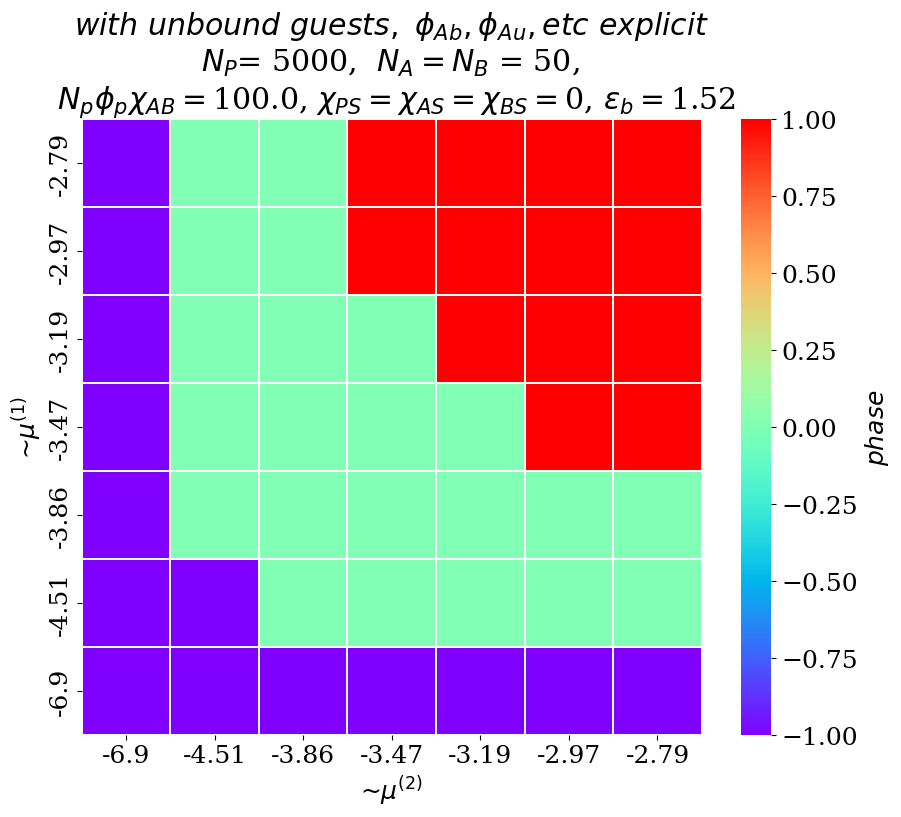

In [25]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(spinodal, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
                 cbar_kws={'label':  r"$phase$"}, vmin=-1, vmax=1)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("~$\mu^{(1)}$")
plt.xlabel("~$\mu^{(2)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$with \ unbound  \ guests, \ \phi_{Ab}, \phi_{Au}, etc \ explicit $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A  \
          +  "\n" +" $N_p \phi_p \chi_{AB} = $" + \
          str(np.round(chi_AB*N_P*phi_p,1)) +", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
         + ", $\epsilon_b = $" + str(e_m[0])) 

# plt.savefig('OABS_phases.png')

#### assymetry investigation

# OLD, mu and $\phi_{Au},\phi_{Bu}$ independent 

FIND AND REPLACE phi_Au_arr to mu1_array; B to 2

In [2]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([0.52, 0.52]) #binding energy FOR F_BIND_ALT
v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_Ab = 0.05
phi_Au = 0.05
phi_Bb = 0.05
phi_Bu = 0.05
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]

# test
mu_max_1 = -2-1.5#8#0.1 #10
mu_min_1 = -4-1.5#-9
# mu_min_1 = -8-1.5#-9
del_mu_1 = 0.1#.5 #0.25
mu_max_2 = mu_max_1
mu_min_2 = mu_min_1
del_mu_2 = del_mu_1

phi_Au_arr = np.arange(mu_min_1, mu_max_1, del_mu_1)
phi_Bu_arr = np.arange(mu_min_2, mu_max_2, del_mu_2)

v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P


psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_Ab, phi_Au, phi_Bb, phi_Bu, \
                    poly_marks, phi_Au_arr, phi_Bu_arr, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = 1
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [3]:
%%time
s_bind_A_ALL, s_bind_B_ALL = calc_binding_states(psol)


CPU times: total: 32.6 s
Wall time: 34.2 s


In [4]:
phi_Au_arr

array([-5.5, -5.4, -5.3, -5.2, -5.1, -5. , -4.9, -4.8, -4.7, -4.6, -4.5,
       -4.4, -4.3, -4.2, -4.1, -4. , -3.9, -3.8, -3.7, -3.6])

Text(0, 0.5, '$\\langle s \\rangle$')

<Figure size 640x480 with 0 Axes>

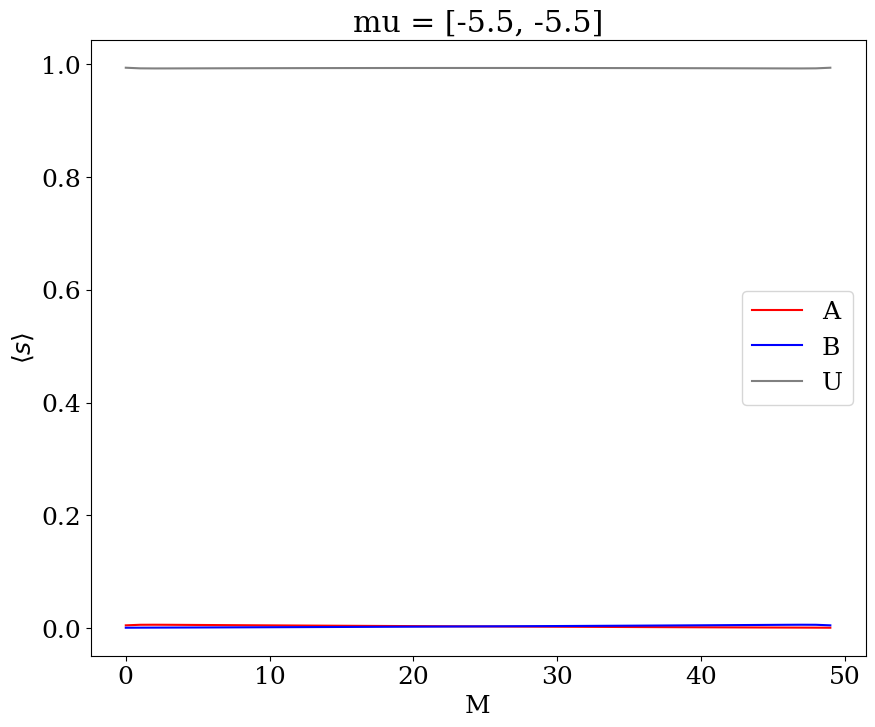

In [9]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

mu1 = -5.5#np.round(-3.8-1.5, 1)
mu2 = -5.5#.2-1.5

mu1_ind = np.where(phi_Au_arr == mu1)[0][0]
mu2_ind = np.where(phi_Bu_arr == mu2)[0][0]

s_bnd_A = s_bind_A_ALL[mu1_ind,mu2_ind,:]
s_bnd_B = s_bind_B_ALL[mu1_ind,mu2_ind,:]
s_unbnd = 1 - (s_bnd_A+s_bnd_B)

plt.plot(np.arange(len(s_bnd_A)), s_bnd_A, color = "red", label = "A")
plt.plot(np.arange(len(s_bnd_A)), s_bnd_B, color = "blue", label = "B")
plt.plot(np.arange(len(s_bnd_A)), s_unbnd, color = "grey", label = "U")
plt.legend()
plt.title(r"mu = [%s, %s]" % (mu1, mu2))
plt.xlabel("M")
plt.ylabel(r"$\langle s \rangle$")

## S2 analysis

In [11]:
corrs = [s_bnd_A, s_bnd_B]
i = 5
j = 5
mu1 = phi_Au_arr[i]
mu2 = phi_Bu_arr[j]

s_bnd_A = s_bind_A_ALL[i, j]
s_bnd_B = s_bind_B_ALL[i, j]
corrs = [s_bnd_A, s_bnd_B]
S_PP = np.zeros(len(k_vec))
S_AP = np.zeros(len(k_vec))
S_BP = np.zeros(len(k_vec))
S_AA = np.zeros(len(k_vec))
S_AB = np.zeros(len(k_vec))
S_BB = np.zeros(len(k_vec))

for ik, k in enumerate(k_vec):
    S2_mat = calc_sf2(psol, corrs, np.array([k]))
    S2_mat = np.array(S2_mat)
    S_PP[ik] = S2_mat[0][0]
    S_AP[ik] = S2_mat[0,1]
    S_BP[ik] = S2_mat[0,2]
    S_AA[ik] = S2_mat[1,1]
    S_AB[ik] = S2_mat[2,1]
    S_BB[ik] = S2_mat[2,2]

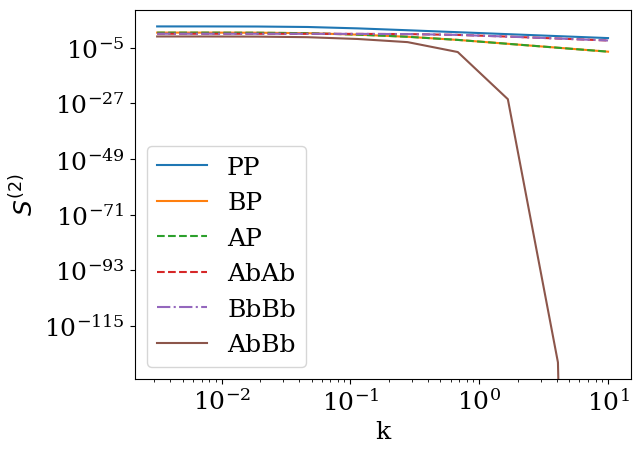

In [12]:
plt.loglog(k_vec, S_PP, label = "PP")
plt.loglog(k_vec, S_BP, label = "BP")
plt.loglog(k_vec, S_AP, linestyle = "--", label = "AP")
plt.loglog(k_vec, S_AA, linestyle = "--", label = "AbAb")
plt.loglog(k_vec, S_BB, linestyle = "-.", label = "BbBb")
plt.loglog(k_vec, S_AB, label = "AbBb")
plt.xlabel("k")
plt.ylabel("$S^{(2)}$")
plt.legend()

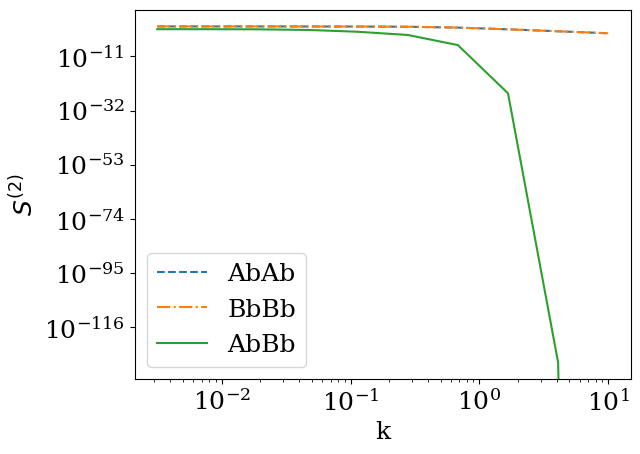

In [13]:
# plt.loglog(k_vec, S_PP)
# plt.loglog(k_vec, S_AP, linestyle = "--")
# plt.loglog(k_vec, S_BP)
plt.loglog(k_vec, S_AA, linestyle = "--", label = "AbAb")
plt.loglog(k_vec, S_BB, linestyle = "-.", label = "BbBb")
plt.loglog(k_vec, S_AB, label = "AbBb")
plt.xlabel("k")
plt.ylabel("$S^{(2)}$")
plt.legend()

With current constants, S2_AbBb (integral) is equivalent to the S2_AbAb, S2_BbBb off-diagonal calculation (slight difference when AbBb corr term compared to AbAb,BbBb corr terms). 
Full S2_AbAb, S2_BbBb calculation includes diagonal (j1==j2) debye function terms, which leads to much slower dropoff and vertical shift.
AbAb, BbBb correaltion dominated by intra-binder, same monomer correlation, whereas AbBb only has larger-scale polymer correlations

## spinodal/ stability analysis

In [7]:
# %%time
# k* stability analysis NUMBER DENSITY THEORY
# chi = 0#5*N/N

chi_AP = 0
chi_BP = 0
chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0

chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]))) 

cond_num_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

for i, mu1 in enumerate(phi_Au_arr):
    for j, mu2 in enumerate(phi_Bu_arr):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
        # print("mu: ", mu)

        for ik, k in enumerate(k_vec):

            # print(k)

            s_bnd_A = s_bind_A_ALL[i, j]
            s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, k, chis)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [17]:
# min_eigval_arr_allk_DENS

In [18]:
# k_star_arr_DENS

In [8]:
# plot such that when -1, disordered, when k_star = k_vec[0], macro; else, micro
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro
# spinodal

Text(0.5, 1.0, '$with \\ unbound  \\ guests, \\ \\phi_{Ab}, \\phi_{Au}, etc \\ explicit $\n$ N_P $= 5000,  $N_A = N_B$ = 50,  $N_p \\phi_p \\chi_{AB} = $69.5, $\\chi_{PS} = \\chi_{AS} = \\chi_{BS} =$0\n$\\epsilon_b = $1.52, $v_{int} = $ [[-4  4],[ 4 -4]]')

<Figure size 640x480 with 0 Axes>

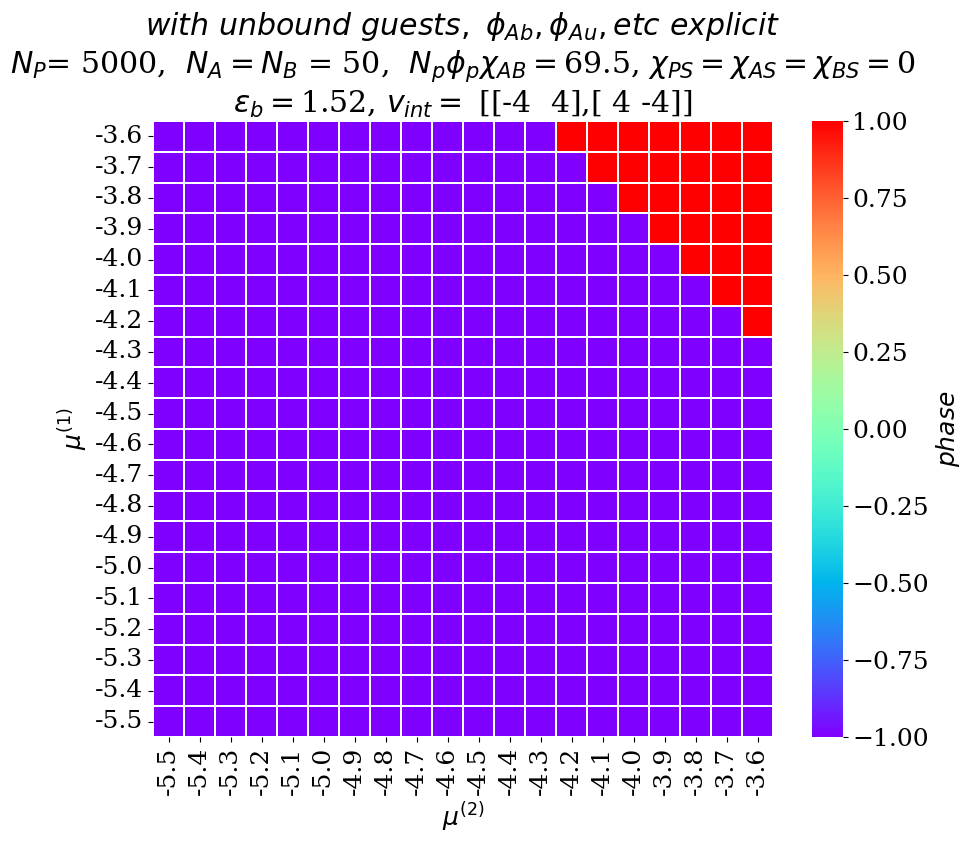

In [9]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


# min_ind = 0
# max_ind = -1

phi_Au_array = np.round(phi_Au_arr, 4)
phi_Bu_array = np.round(phi_Bu_arr, 4)
# plt.scatter(phi_Au_array[np.where(multi_soln_mus == 1)[0]],phi_Bu_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=phi_Bu_array, yticklabels=phi_Au_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(spinodal, linewidth=0.25, cmap = "rainbow", xticklabels=phi_Bu_array, yticklabels=phi_Au_array,\
                 cbar_kws={'label':  r"$phase$"}, vmin=-1, vmax=1)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(phi_Bu_array[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(phi_Au_array[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$with \ unbound  \ guests, \ \phi_{Ab}, \phi_{Au}, etc \ explicit $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
          str(chi_AB*N_P*phi_p) \
          + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
           +\
          "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 

# plt.savefig('OABS_phases.png')

In [21]:
# S2_mat = np.array([[-99966970.91418333, 5.955472724699314, 5.955472724699317, 0, 0, 0], \
#           [5.955472724699314, -17199483.03414897, 0.009998139340788366, 0, 0, 0], \
#           [5.955472724699317, 0.009998139340788366, -17199483.03414896, 0, 0, 0], \
#           [0, 0, 0, -14398800099.995834, 0, 0], \
#           [0, 0, 0, 0, -14398800099.995834, 0], \
#           [0, 0, 0, 0, 0, 0.10000000000000003]])

In [22]:
# # spinodal_phases_shift = np.copy(phases)
# # spinodal_phases_shift[np.where(phases!=0)] = -1

# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1
# spinodal_phases_shift = np.copy(k_star_arr_DENS)
# spinodal_phases_shift[np.where(k_star_arr_DENS<0)] = 0
# spinodal_phases_shift[np.where(k_star_arr_DENS>0)] = -1

# X = spinodal_phases_shift

# upper = np.triu(X)
# # upper[np.where(upper == 0)] = 0

# lower = np.tril(X)
# # lower[np.where(lower == 0)] = 0

# # WORKS!
# phi_Au_array= phi_Au_arr
# phi_Bu_array= phi_Bu_arr

# spin_right = np.zeros((X.shape[0],2))
# spin_left = np.zeros((X.shape[0],2))

# for i in range(X.shape[0]): # for each row in spinodal diagram (mu1 row)
#     #find crossover arr
#     mu1 = phi_Au_array[i]
#     # print("mu1: ", mu1)
#     # a = upper[i]
#     a = X[i]
#     asign = np.sign(a)
#     signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
#     signchange[0] = 0
#     # print(signchange)

#     if np.sum(signchange) == 0: # no boundary at this 
#         mu2_vals = [np.nan]
#         # spin_left[i] = [mu1, mu2_vals[0]]
#         spin_right[i] = [mu1, mu2_vals[0]] 
#         spin_left[i] = [mu1, mu2_vals[0]]

#     elif np.sum(signchange) == 1: # outer boundary cut off
#         mu2_vals = phi_Bu_array[np.where(signchange==1)]
#         spin_left[i] = [mu1, mu2_vals[0]]
#         spin_right[i] = [mu1, np.nan] 
#     else:
#         mu2_vals = phi_Bu_array[np.where(signchange==1)]
#         spin_left[i] = [mu1, np.min(mu2_vals)]
#         spin_right[i] = [mu1, np.max(mu2_vals)] 

# # a = cyl_right_inner
# spin_left = spin_left[~np.isnan(spin_left).any(axis=1)]    
# # cyl_right_outer = spin_left[~np.isnan(spin_left).any(axis=1)]    
# spin_right = spin_right[~np.isnan(spin_right).any(axis=1)]    
# # cyl_left_outer = cyl_left_outer[~np.isnan(cyl_left_outer).any(axis=1)]  

# spin_right_app = np.vstack([spin_left[0], spin_right])
# spin_left_app = np.vstack([spin_right[0], spin_left])